In [1]:
import os
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is DC85-82A4

 Directory of d:\Github\DanhgiaDuAnVaNghenghiepTuongLai\code_ai\TestCode_ver3

06/13/2024  05:40 PM    <DIR>          .
06/13/2024  04:52 PM    <DIR>          ..
06/13/2024  05:40 PM                30 config.txt
06/13/2024  01:00 PM             4,601 predict.ipynb
06/13/2024  04:17 PM                 0 run.md
06/13/2024  05:08 PM           183,759 RunCode1.ipynb
06/13/2024  05:40 PM            16,860 uncategorized_projects.csv
               5 File(s)        205,250 bytes
               2 Dir(s)  26,694,197,248 bytes free


In [3]:
# Xóa file mô hình cũ nếu tồn tại
if os.path.exists('best_model.keras'):
    os.remove('best_model.keras')
    os.remove('categories.joblib')
    os.remove('tokenizer.joblib')
    os.remove('uncategorized_projects.csv')

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Hàm xây dựng mô hình tối ưu
def build_model(vocab_size, num_classes, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Sử dụng activation 'sigmoid' cho phân loại đa nhãn
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# Hàm vẽ biểu đồ
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Biểu đồ Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Biểu đồ Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# Tạo từ điển ánh xạ với nhóm từ khóa cho mỗi chủ đề
technically = {
    'website': ['website', 'web'],
    'mobile-app': ['mobile app', 'app di động', 'Xây dựng ứng dụng', 'Xây dựng Ứng dụng', 'Ứng dụng di động', 'Phát triển ứng dụng', 'Xây dựng ứng dụng'],
    'game': ['game', 'trò chơi'],
    'chatbot': ['chatbot', 'chat bot'],
    'artificial-intelligence': ['trí tuệ nhân tạo'],
    'machine-learning': ['machine learning', 'máy học'],
    'deep-learning': ['deep learning', 'học sâu'],
    'computer-vision': ['computer vision', 'thị giác máy tính'],
    'big-data': ['big data', 'dữ liệu lớn', 'bigdata'],
    'data-analysis': ['data analysis', 'phân tích dữ liệu'],
    'cloud-computing': ['cloud computing', 'điện toán đám mây', 'K8s', 'kubernetes'],
    'blockchain': ['blockchain', 'chuỗi khối', 'NFT'],
    'robot': ['robot', 'robotics', 'robotic'],
    'drone': ['drone', 'flycam'],
    'vr': ['vr', 'thực tế ảo', 'virtual reality'],
    'iot': ['nhà thông minh', 'thiết bị thông minh'],
}

In [8]:
# Tải dữ liệu
pd_data = pd.read_csv('D:/Github/DanhgiaDuAnVaNghenghiepTuongLai/dataset/dataset_train_ver1.csv')
pd_data

,STT,nameProject_VNI,nameProject_ENG,difficulty_level,codeSememter,major,specialization,university,note
0,1.0,Xây dựng hệ thống quản lý sân cầu lông,NaN,1.0,232.0,NaN,NaN,UIT,NaN
1,2.0,Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...,NaN,1.0,232.0,NaN,NaN,UIT,NaN
2,3.0,Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...,NaN,1.0,232.0,NaN,NaN,UIT,NaN
3,4.0,Xây dựng mạng xã hội kết hợp chatbot cho người...,NaN,1.0,232.0,NaN,NaN,UIT,NaN
4,5.0,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,NaN,1.0,232.0,NaN,NaN,UIT,NaN
...,...,...,...,...,...,...,...,...,...
613,NaN,Tìm hiểu về phân tích dữ liệu trong kinh doanh,NaN,1.0,232.0,NaN,NaN,HUTECH,Hướng nghiên cứu
614,NaN,Xây dựng ứng dụng để quản lý thiết bị thông minh,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615,NaN,Ứng dụng AI trong phân tích y học,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,NaN,Dùng website để quản trị nhà máy điện,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_train = pd_data[['nameProject_VNI']].copy()

# Đếm số lần xuất hiện của mỗi tên dự án
project_counts = df_train['nameProject_VNI'].value_counts()
# Hiển thị các tên dự án có số lần xuất hiện nhiều hơn 1
duplicate_projects = project_counts[project_counts > 1]
print(duplicate_projects)

nameProject_VNI
Nghiên cứu và thử nghiệm một số phương pháp định giá BĐS                                                                          4
Phát triển ứng dụng phân tích dữ liệu y khoa trong xét nghiệm máu                                                                 3
Tìm hiểu Thị giác máy tính vận dụng trong phát triển ứng dụng Game 3D tương tác, Thực thể ảo AR.                                  3
Xây dựng hệ thống quản lý đề tài Đồ án chuyên ngành Khoa CNPM                                                                     2
Dự báo qua hành vi mua sắm của người tiêu dùng trong hoạt động kinh doanh hàng tiêu dùng                                          2
Xây dựng hệ thống tư vấn chọn ngành Đại học cho học sinh Trung học Phổ Thông                                                      2
Phát triển ứng dụng hỗ trợ trẻ em tự kỷ                                                                                           2
Ứng dụng gọi xe chung cho sinh viên                         

In [10]:
# Lọc và hiển thị các bản ghi có tên dự án trùng lặp
duplicates = df_train[df_train['nameProject_VNI'].isin(duplicate_projects.index)]
# print(duplicates)

# Loại bỏ các trùng lặp, chỉ giữ lại bản ghi đầu tiên
df = df_train.drop_duplicates(subset=['nameProject_VNI'], keep='first')

In [11]:
# Đếm số lần xuất hiện của mỗi tên dự án
project_counts = df['nameProject_VNI'].value_counts()
# Hiển thị các tên dự án có số lần xuất hiện nhiều hơn 1
duplicate_projects = project_counts[project_counts > 1]
print(duplicate_projects)

Series([], Name: count, dtype: int64)


In [12]:
# df['category'] = df['nameProject_VNI'].apply(categorize_project)
# # pd_data
print(df)

                                       nameProject_VNI
0               Xây dựng hệ thống quản lý sân cầu lông
1    Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...
2    Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...
3    Xây dựng mạng xã hội kết hợp chatbot cho người...
4    Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...
..                                                 ...
613     Tìm hiểu về phân tích dữ liệu trong kinh doanh
614   Xây dựng ứng dụng để quản lý thiết bị thông minh
615                  Ứng dụng AI trong phân tích y học
616              Dùng website để quản trị nhà máy điện
617      Lập trình trí tuệ nhân tạo để dự đoán giá nhà

[572 rows x 1 columns]


In [13]:
# Hàm phân loại chủ đề
def categorize_project(project_name):
    matched_themes = []
    for theme, keywords in technically.items():
        if any(keyword.lower() in project_name.lower() for keyword in keywords):
            matched_themes.append(theme)
    return ', '.join(matched_themes) if matched_themes else None

# Assuming df is your DataFrame and it's already defined
# Make sure to directly modify the 'category' column in a safe manner
df.loc[:, 'category'] = df['nameProject_VNI'].apply(lambda x: categorize_project(x) if categorize_project(x) else '')

# Tìm các hàng không có category được phân loại và lưu vào một file CSV mới
uncategorized_df = df[df['category'] == '']
uncategorized_df.to_csv('uncategorized_projects.csv', index=False, encoding='utf-8')

# Hiển thị các hàng không có category được phân loại
print("Các hàng không có category được phân loại:")
print(df[df['category'] == ''])

# Loại bỏ các hàng không có category được phân loại
df = df[df['category'] != '']

# Hiển thị DataFrame đã cập nhật
print("\nDataFrame sau khi loại bỏ các hàng không có category được phân loại:")
print(df)

Các hàng không có category được phân loại:
                                       nameProject_VNI category
0               Xây dựng hệ thống quản lý sân cầu lông         
2    Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...         
6    Nghiên cứu và thử nghiệm một số phương pháp đị...         
8    Xây dựng hệ thống quản lý phòng trọ và gợi ý c...         
10   Xây dựng Shop quần áo online tích hợp gợi ý sả...         
..                                                 ...      ...
607                                Tìm hiểu về MongoDB         
608                          Tìm hiểu về Elasticsearch         
610                         Tìm hiểu về Data Warehouse         
611  Tìm hiểu phương pháp phân tích tương tác sản p...         
615                  Ứng dụng AI trong phân tích y học         

[233 rows x 2 columns]

DataFrame sau khi loại bỏ các hàng không có category được phân loại:
                                       nameProject_VNI  \
1    Tìm hiểu công nghệ Web 3.0 và ứn

C:\Users\huuth\AppData\Local\Temp\ipykernel_19124\2738154831.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category'] = df['nameProject_VNI'].apply(lambda x: categorize_project(x) if categorize_project(x) else '')


<Axes: xlabel='count', ylabel='university'>

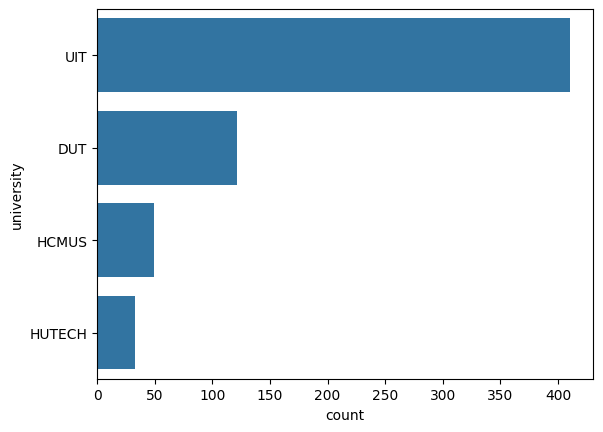

In [14]:
# UIT: Đại học Công nghệ thông tin HCM
# DUT: Đại học Đại học Bách Khoa - Đại học Đà Nẵng
# HCMUS: Đại học Khoa học Tự nhiên - Đại học Quốc gia TP.HCM
import seaborn as sns
sns.countplot(pd_data['university'])

In [15]:
# Số lượng đồ án của từng trường ĐH
pd_data['university'].value_counts()

university
UIT       410
DUT       121
HCMUS      49
HUTECH     33
Name: count, dtype: int64

In [16]:
# Tạo các cột chỉ báo cho mỗi chủ đề
category_dummies = pd.get_dummies(df['category'].apply(lambda x: x.split(', ')).explode()).groupby(level=0).sum()
df = pd.concat([df, category_dummies], axis=1)
df

,nameProject_VNI,category,artificial-intelligence,big-data,blockchain,chatbot,cloud-computing,computer-vision,data-analysis,deep-learning,drone,game,iot,machine-learning,mobile-app,robot,website
1,Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...,website,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Xây dựng mạng xã hội kết hợp chatbot cho người...,chatbot,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,"mobile-app, chatbot",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,"mobile-app, chatbot",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
7,Phân tích xu hướng bất động sản bằng Machine L...,machine-learning,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,Tìm hiểu một số phương pháp phân tích dữ liệu ...,"machine-learning, data-analysis",0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
613,Tìm hiểu về phân tích dữ liệu trong kinh doanh,data-analysis,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
614,Xây dựng ứng dụng để quản lý thiết bị thông minh,"mobile-app, iot",0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
616,Dùng website để quản trị nhà máy điện,website,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:
# Lấy văn bản dự án và các nhãn
texts = df['nameProject_VNI'].values
categories = df.columns.difference(['nameProject_VNI', 'category'])
labels = df[categories].values

In [18]:
categories

Index(['artificial-intelligence', 'big-data', 'blockchain', 'chatbot',
       'cloud-computing', 'computer-vision', 'data-analysis', 'deep-learning',
       'drone', 'game', 'iot', 'machine-learning', 'mobile-app', 'robot',
       'website'],
      dtype='object')

In [19]:
print(labels)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]]


In [20]:
# Chuẩn bị tokenizer và padding
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(texts)
# Chuyển đổi văn bản thành chuỗi số
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences, maxlen=max_length)

# Lưu các thông tin vào file txt
with open('config.txt', 'w') as file:
    file.write(f'MaxLength:{max_length}\n')
    file.write(f'NumWords:{num_words}\n')

In [21]:
# Chia dữ liệu thành huấn luyện và thử nghiệm
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [22]:
num_classes = y_train.shape[1]  # Đảm bảo num_classes bằng với kích thước thứ hai của y_train

# Khởi tạo mô hình
model = build_model(vocab_size=10000, num_classes=num_classes, input_length=max_length)

c:\Users\huuth\miniconda3\envs\dacs\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
print("Số lượng nhãn (num_classes):", num_classes)
print("Shape của y_train:", y_train.shape)
print("Shape của y_test:", y_test.shape)

Số lượng nhãn (num_classes): 15
Shape của y_train: (271, 15)
Shape của y_test: (68, 15)


In [24]:
# Early stopping và checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [25]:
num_rows = X_train.shape[0]
print(f"Số lượng hàng trong dữ liệu train là {num_rows}")
batch_size_options = [16, 32, 64]  # Các lựa chọn thử nghiệm

# Chọn batch size dựa trên hiệu suất của mô hình
batch_size = min(batch_size_options, key=lambda x: abs(x - num_rows//x * x))

print(f"Batch size được chọn: {batch_size}")

Số lượng hàng trong dữ liệu train là 271
Batch size được chọn: 64


In [26]:
history = []
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=500, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.0838 - loss: 0.9917 - val_accuracy: 0.2353 - val_loss: 0.6826
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1974 - loss: 0.9209 - val_accuracy: 0.2353 - val_loss: 0.6734
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3185 - loss: 0.8335 - val_accuracy: 0.2206 - val_loss: 0.6638
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4167 - loss: 0.8290 - val_accuracy: 0.2206 - val_loss: 0.6551
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5387 - loss: 0.7796 - val_accuracy: 0.2941 - val_loss: 0.6464
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6359 - loss: 0.7441 - val_accuracy: 0.6324 - val_loss: 0.6359
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6677 - loss: 0.7239 - val_accuracy: 0.6912 - val_loss: 0.6268
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6871 - loss: 0.7065 - val_accuracy: 0.6765 - val_lo

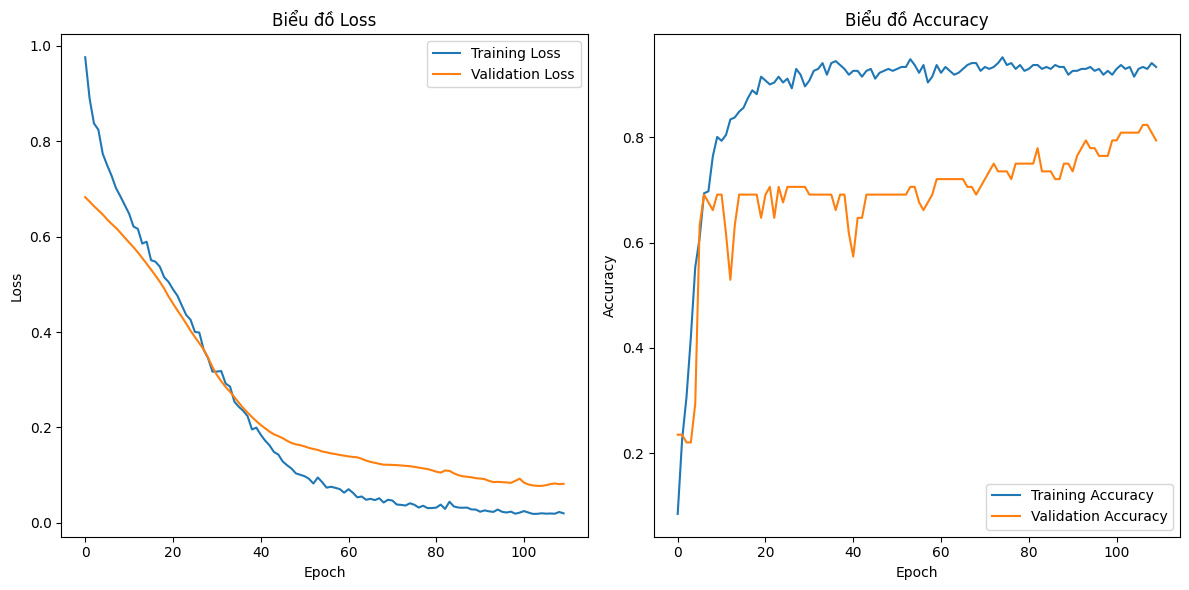

In [27]:
# Vẽ biểu đồ loss và accuracy
plot_history(history)

In [28]:
print(f"Số lượng categories: {len(categories)}")
print(f"Số lượng outputs của mô hình: {num_classes}")

Số lượng categories: 15
Số lượng outputs của mô hình: 15


In [29]:
# Lưu tokenizer và categories
joblib.dump(categories, 'categories.joblib')
joblib.dump(tokenizer, 'tokenizer.joblib')

# Định nghĩa và sử dụng hàm dự đoán
def predict_project_category(project_name):
    # Chuyển đổi tên dự án thành chuỗi số
    sequence = tokenizer.texts_to_sequences([project_name])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)  # Sử dụng max_length đã xác định khi huấn luyện

    # Thực hiện dự đoán
    prediction = model.predict(padded_sequence)
    predicted_categories = (prediction > 0.1).astype(int)

    # Ánh xạ dự đoán thành tên chủ đề
    predicted_labels = [categories[idx] for idx, is_present in enumerate(predicted_categories[0]) if is_present]
    return ', '.join(predicted_labels) if predicted_labels else 'Không xác định'

In [30]:
# Computer Science - AI
# Xây dựng hệ thống chatbot tự động tư vấn tuyển sinh
# Dự đoán doanh thu bán hàng dựa trên phân tích dữ liệu
# Phân loại cảm xúc trong văn bản tiếng Việt
# Nhận dạng giọng nói và chuyển đổi thành văn bản tiếng Việt
# Hệ thống phát hiện gian lận giao dịch ngân hàng
# Ứng dụng AI trong phân tích y học
# Xây dựng hệ thống đề xuất sản phẩm dựa trên sở thích khách hàng
# Phân loại ảnh và nhận diện đối tượng trong môi trường thực tế
# Hệ thống quản lý học tập thông minh
# Tối ưu hóa lộ trình vận chuyển hàng hóa

# Dùng website để mua đồ chơi cho trẻ
# Dùng website để quản trị nhà máy điện
# Xây dựng ứng dụng để quản lý thiết bị thông minh - X

In [32]:
# project_name = "Xây dựng ứng dụng để quản lý thiết bị thông minh"
project_name = "Lập trình trí tuệ nhân tạo để dự đoán giá nhà"
# project_name = "Dùng website để quản trị nhà máy điện" # Ngoài lề - đã add
# project_name = "Ứng dụng AI trong phân tích y học" # Ngoài lề - đã add
# project_name = "Xây dựng hệ thống chatbot tự động tư vấn tuyển sinh" # X
# project_name = "Dùng website để mua đồ chơi cho trẻ" # Ok
predicted_category = predict_project_category(project_name)
print(f"Đề tài: {project_name}\nThuộc các chủ đề: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Đề tài: Lập trình trí tuệ nhân tạo để dự đoán giá nhà
Thuộc các chủ đề: artificial-intelligence
